# Rossman Sales Prediction - Part 2

# Imports

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Settings and Auxiliary Functions

In [2]:
plt.rcParams["figure.figsize"] = [9,6]
sns.set_theme()

In [3]:
def calc_error( model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    return pd.DataFrame({"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse}, index=[0])

In [58]:
def plot_scatter(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(6,5))
    min_x, max_x = y_test.min(), y_test.max()
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min_x, max_x],[min_x, max_x])
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    return None  

# Data Loading

In [121]:
data = pd.read_csv("filtered_data.cvs", low_memory=False, index_col=0)

In [122]:
data.head()

,Store,DayOfWeek,Date,Sales,Promo,StoreType,Assortment,Promo2
0,1,5,2015-07-31,5263,1,c,basic,0
1,2,5,2015-07-31,6064,1,a,basic,1
2,3,5,2015-07-31,8314,1,a,basic,1
3,4,5,2015-07-31,13995,1,c,extended,0
4,5,5,2015-07-31,4822,1,a,basic,0


In [128]:
data["Date"] = data["Date"].astype("datetime64")

# Data Preparation

## Encoding

In [124]:
le = LabelEncoder()
data["StoreType"] = le.fit_transform(data["StoreType"])

data["Assortment"] = data["Assortment"].map({"basic":1, "extra":2, "extended":3})

## Cyclical Variables

In [129]:
data["Day"] = data["Date"].dt.day
data["Month"] = data["Date"].dt.month
data["Year"] = data["Date"].dt.year
data["Week"] = data["Date"].dt.isocalendar().week

In [130]:
data["Day_sin"] = data["Day"].apply(lambda x: np.sin(x * np.pi/31))
data["Day_cos"] = data["Day"].apply(lambda x: np.cos(x * np.pi/31))

data["DayOfWeek_sin"] = data["DayOfWeek"].apply(lambda x: np.sin(x * np.pi/7))
data["DayOfWeek_cos"] = data["DayOfWeek"].apply(lambda x: np.cos(x * np.pi/7))

data["Week_sin"] = data["Week"].apply(lambda x: np.sin(x * np.pi/52))
data["Week_cos"] = data["Week"].apply(lambda x: np.cos(x * np.pi/52))

data["Month_sin"] = data["Month"].apply(lambda x: np.sin(x * np.pi/12))
data["Month_cos"] = data["Month"].apply(lambda x: np.cos(x * np.pi/12))

In [131]:
data = data.drop(columns=["DayOfWeek", "Day", "Month", "Week"])

## Target Variable Transformation

In [132]:
data["Sales"] = np.log(data["Sales"])

# Feature Selection

## Test-train Split

In [133]:
aux = data.copy()

In [138]:
time_cutoff = aux["Date"].max() - datetime.timedelta(days=42)

train_df = aux[aux["Date"] < time_cutoff]

test_df = aux[aux["Date"] >= time_cutoff]


# Model Training

## Baseline (Average) Model

In [103]:
aux1 = X_train.copy()
aux1["Sales"] = y_train.copy()
aux1 = aux1[["Store", "Sales"]].groupby("Store").mean().reset_index()

aux2 = X_test.copy()
bl_pred = pd.merge(aux1, aux2, how="right", on="Store")["Sales"]

baseline_error = calc_error("Baseline", np.exp(y_test).values, np.exp(bl_pred))
baseline_error

,Model,MAE,MAPE,RMSE
0,Baseline,1429.764812,0.216813,1939.336071


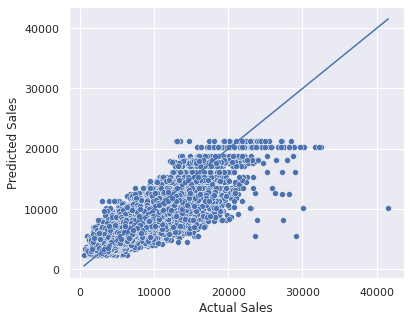

In [104]:
plot_scatter(np.exp(y_test).values, np.exp(bl_pred))

## Linear Regression

In [119]:
lr = LinearRegression().fit(X_train, y_train)
l_pred = lr.predict(X_test)
linear_error = calc_error("Linear Regression", np.exp(y_test), np.exp(l_pred))
linear_error

,Model,MAE,MAPE,RMSE
0,Linear Regression,1872.234082,0.295008,2676.976699


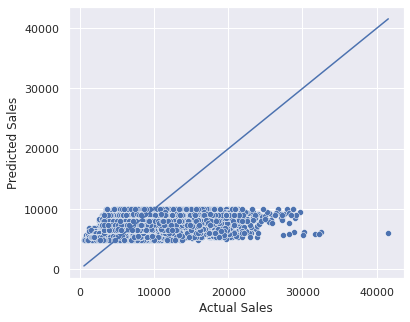

In [120]:
plot_scatter(np.exp(y_test), np.exp(l_pred))

## Random Forest Regression

In [109]:
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_error = calc_error("Random Forest", np.exp(y_test), np.exp(rf_pred))

In [110]:
rf_error

,Model,MAE,MAPE,RMSE
0,Random Forest,793.696372,0.117648,1219.825662


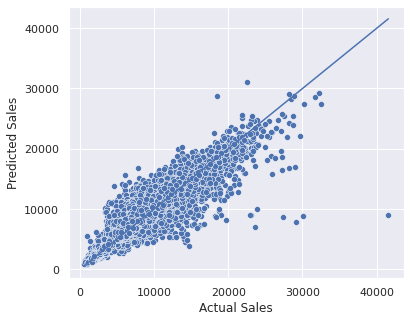

In [111]:
plot_scatter(np.exp(y_test), np.exp(y_pred))

In [116]:
aux = pd.DataFrame(rf.feature_importances_).T
aux.columns = X_test.columns
aux.T


,0
Store,0.561815
Promo,0.162220
StoreType,0.056532
Assortment,0.025197
Promo2,0.018932
Year,0.016009
Day_sin,0.025141
Day_cos,0.023552
DayOfWeek_sin,0.019890
DayOfWeek_cos,0.031679


In [112]:
X_test.head()

,Store,Promo,StoreType,Assortment,Promo2,Year,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Month_sin,Month_cos
0,1,1,2,1,0,2015,1.224647e-16,-1.0,0.781831,-0.62349,0.954721,-0.297503,0.965926,-0.258819
1,2,1,0,1,1,2015,1.224647e-16,-1.0,0.781831,-0.62349,0.954721,-0.297503,0.965926,-0.258819
2,3,1,0,1,1,2015,1.224647e-16,-1.0,0.781831,-0.62349,0.954721,-0.297503,0.965926,-0.258819
3,4,1,2,3,0,2015,1.224647e-16,-1.0,0.781831,-0.62349,0.954721,-0.297503,0.965926,-0.258819
4,5,1,0,1,0,2015,1.224647e-16,-1.0,0.781831,-0.62349,0.954721,-0.297503,0.965926,-0.258819


In [17]:
rf.estimators_[0].tree_.children_left

array([      1,       2,       3, ..., 1014701,      -1,      -1],
      dtype=int64)

In [45]:
rf.estimators_[0].feature_importances_

array([0.55615634, 0.16308157, 0.05836102, 0.02523247, 0.01934114,
       0.01553172, 0.02533741, 0.02527898, 0.02846857, 0.02457657,
       0.01056859, 0.03181811, 0.00854939, 0.00769812])

In [46]:
rf.

array([0.56181491, 0.16222049, 0.05653181, 0.0251971 , 0.01893244,
       0.01600921, 0.02514145, 0.02355165, 0.01988968, 0.03167885,
       0.01147041, 0.0312376 , 0.00648466, 0.00983976])

In [47]:
from sklearn import tree

In [ ]:
tree.plot_tree(rf.estimators_[0])

In [54]:
y_pred.min()

6.698000225210672

In [55]:
y_test.min()

6.343880434126331